# Evaluación de modelos y validación de resultados (IAM)

En este notebook se realiza la evaluación comparativa de los modelos entrenados en el anterior Notebook 3, centrándose en métricas cuantitativas y criterios operativos adecuados para un enfoque no supervisado.

Dado que el dataset no dispone de etiquetas, la evaluación se basa en:

- Distribución de scores de anomalía (visión global del comportamiento del modelo).
- Tasa de alerta o presupuesto de revisión (cuánto trabajo manual reduce).
- Consenso Top-K entre modelos (robustez sin depender de revisión manual).
- Coste computacional y reproducibilidad (mediante parámetros y configuración guardada).

El objetivo es determinar qué modelo resulta más útil para priorizar revisiones en entornos IAM, minimizando el coste manual asociado a la inspección de accesos.


## Carga de resultados

Se van a cargar los ficheros generados. Estos ficheros contienen los scores calculados por cada modelo, junto con información de trazabilidad cuando está disponible.

In [2]:
import pandas as pd
import json

IF_PATH = "isolation_forest.parquet"  
AE_PATH = "autoencoders.parquet"

if_pred = pd.read_parquet(IF_PATH)
ae_pred = pd.read_parquet(AE_PATH)

print("IF:", if_pred.shape)
print("AE:", ae_pred.shape)

print("Columnas IF:", list(if_pred.columns))
print("Columnas AE:", list(ae_pred.columns))

if_pred.head()

IF: (42866142, 4)
AE: (42866142, 3)
Columnas IF: ['iso_score', 'iso_label', 'dt', 'src_user']
Columnas AE: ['ae_score', 'dt', 'src_user']


,iso_score,iso_label,dt,src_user
0,-0.213920,-1,1970-01-01 00:00:00,ANONYMOUS LOGON@C1065
1,0.093414,1,1970-01-01 00:00:00,U561@DOM1
2,0.086292,1,1970-01-01 00:00:00,U556@DOM1
3,-0.076311,-1,1970-01-01 00:00:00,U555@DOM1
4,0.023536,1,1970-01-01 00:00:00,U553@DOM1


## Metadatos y reproducibilidad

Se cargan los ficheros JSON con la configuración de entrenamiento (features y parámetros).
Esto permite documentar el experimento y asegurar reproducibilidad de resultados.

In [3]:
with open("run_if_info.json", "r") as f:
    if_info = json.load(f)

with open("run_ae_info.json", "r") as f:
    ae_info = json.load(f)

if_info, ae_info

({'model': 'IsolationForest',
  'features': ['total_events',
   'failed_events',
   'fail_ratio',
   'dst_hosts',
   'src_hosts',
   'nbhours_events',
   'nbhours_ratio'],
  'scaler': 'StandardScaler',
  'params': {'n_estimators': 200, 'contamination': 0.05, 'random_state': 42}},
 {'model': 'Autoencoder',
  'features': ['total_events',
   'failed_events',
   'fail_ratio',
   'dst_hosts',
   'src_hosts',
   'nbhours_events',
   'nbhours_ratio'],
  'scaler': 'StandardScaler',
  'params': {'epochs': 5,
   'batch_size': 4096,
   'latent_dim': 3,
   'optimizer': 'Adam',
   'loss': 'MSE'}})

## Unión de resultados

Para comparar modelos de forma directa, se va a unificar las predicciones en un único dataframe.
Si existen columnas de trazabilidad comunes (por ejemplo `dt` y `src_user`), se realiza un merge por estas claves. En caso contrario, se asume que ambos ficheros mantienen el mismo orden de filas y se concatena por índice.

In [4]:
keys = [c for c in ["dt", "src_user"] if c in if_pred.columns and c in ae_pred.columns]
print("Keys (t razabilidad):", keys)

if keys:
    df_eval = if_pred.merge(ae_pred, on=keys, how="inner")
else:
    df_eval = pd.concat([if_pred, ae_pred], axis=1)

print("EVAL:", df_eval.shape)
df_eval.head()


Keys (t razabilidad): ['dt', 'src_user']
EVAL: (94332184, 5)


,iso_score,iso_label,dt,src_user,ae_score
0,-0.213920,-1,1970-01-01 00:00:00,ANONYMOUS LOGON@C1065,0.360894
1,0.093414,1,1970-01-01 00:00:00,U561@DOM1,0.000495
2,0.086292,1,1970-01-01 00:00:00,U556@DOM1,0.000551
3,-0.076311,-1,1970-01-01 00:00:00,U555@DOM1,0.005807
4,0.023536,1,1970-01-01 00:00:00,U553@DOM1,0.002181


## Distribución de scores de anomalía

Se analiza la distribución global de scores para cada modelo. Este análisis permite observar:
- si existe una “cola” de anomalías (valores extremos),
- si el score presenta una concentración clara (comportamiento mayoritario),
- si el modelo produce separación útil para priorización.

En Isolation Forest, scores más bajos indican mayor anomalía.
En Autoencoder, scores más altos (error de reconstrucción) indican mayor anomalía.

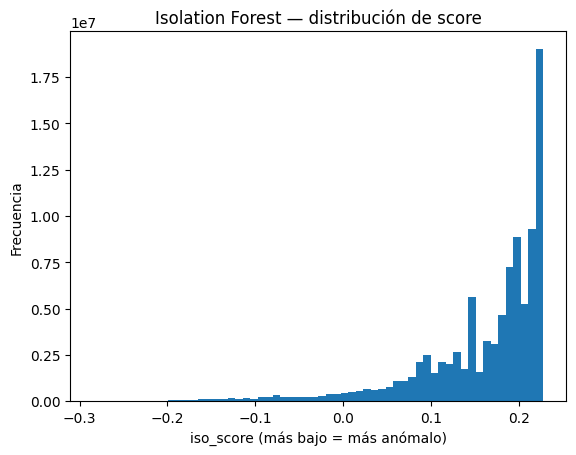

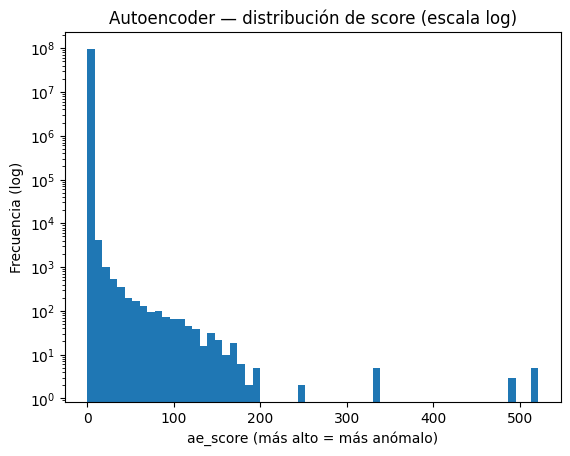

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_eval["iso_score"], bins=60)
plt.title("Isolation Forest — distribución de score")
plt.xlabel("iso_score (más bajo = más anómalo)")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
plt.hist(df_eval["ae_score"], bins=60)
plt.yscale("log")
plt.title("Autoencoder — distribución de score (escala log)")
plt.xlabel("ae_score (más alto = más anómalo)")
plt.ylabel("Frecuencia (log)")
plt.show()

## Tasa de alerta y presupuesto de revisión (reducción de coste manual)

En un contexto IAM real, no es viable revisar todos los accesos/perfiles. Por ello, se defineun presupuesto de revisión (porcentaje o número Top-K) que representa el volumen de casos que un equipo podría revisar.

- En IF, la tasa de alerta puede estimarse directamente mediante 'iso_label'.
- En AE, al no existir etiqueta, se define un Top-K o Top-% a revisar según el score.

In [6]:
if "iso_label" in df_eval.columns:
    alert_rate_if = (df_eval["iso_label"] == -1).mean()
    print("Alert rate IF:", f"{alert_rate_if:.2%}")
else:
    print("No hay iso_label en IF: se trabajará con Top-K basado en iso_score.")

N = len(df_eval)
budget = 0.01
K_budget = int(N * budget)
print("N total:", N, "| Budget:", f"{budget:.2%}", "| K:", K_budget)

Alert rate IF: 4.72%
N total: 94332184 | Budget: 1.00% | K: 943321


In [7]:
iso_table = df_eval["iso_score"].describe(percentiles=[0.95, 0.99])
iso_table

count    9.433218e+07
mean     1.599734e-01
std      7.511728e-02
min     -2.851411e-01
95%      2.276450e-01
99%      2.276450e-01
max      2.276450e-01
Name: iso_score, dtype: float64

In [8]:
ae_table = df_eval["ae_score"].describe(percentiles=[0.95, 0.99])
ae_table

count    9.433218e+07
mean     6.327880e-03
std      3.880112e-01
min      8.723942e-05
95%      4.417099e-03
99%      2.820506e-02
max      5.212789e+02
Name: ae_score, dtype: float64

## Top-K entre modelos (validación sin etiquetas)

Una forma robusta de validación sin ground truth es analizar el consenso:
si dos modelos basados en paradigmas distintos (árboles vs reconstrucción) coinciden en parte de los casos más anómalos, esos casos son candidatos especialmente relevantes para revisión.

Se mide el solapamiento (overlap) entre:
- Top-K de IF (scores más bajos)
- Top-K de AE (scores más altos)


In [9]:
K = 10000  # ajusta según tu presupuesto operativo

top_if = set(df_eval.nsmallest(K, "iso_score").index)
top_ae = set(df_eval.nlargest(K, "ae_score").index)

overlap = len(top_if & top_ae)
print("Overlap Top-K:", overlap, f"({overlap/K:.2%})")

Overlap Top-K: 2818 (28.18%)


Un solapamiento del 28,18% indica que una proporción significativa de los perfiles más anómalos es detectada de forma consistente por ambos modelos, lo que refuerza la confianza en dichos casos como candidatos prioritarios para revisión.

# Identificación del consenso

Se extraen los perfiles que estan en el Top-K de IF y en el Top-K de AE para crear un subconjunto de máxima confianza.

In [10]:
import numpy as np

DATA_PATH = "lanl_db_feature.csv"  # ajusta si tu fichero se llama distinto
df = pd.read_csv(DATA_PATH)

df.head()

,dt,src_user,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio
0,1970-01-01 00:00:00,ANONYMOUS LOGON@C1065,434,0,0.0,1,82,434,1.0
1,1970-01-01 00:00:00,U561@DOM1,17,0,0.0,3,4,17,1.0
2,1970-01-01 00:00:00,U556@DOM1,20,0,0.0,5,4,20,1.0
3,1970-01-01 00:00:00,U555@DOM1,49,0,0.0,9,10,49,1.0
4,1970-01-01 00:00:00,U553@DOM1,30,0,0.0,6,7,30,1.0


In [11]:
keys = [c for c in ["dt","src_user"] if c in df.columns and c in df_eval.columns]
df_full = df_eval.merge(df, on=keys, how="left")
print(df_full.shape)

(227233812, 12)


In [12]:
K = 10000  # el mismo K usado antes

top_if_idx = set(df_full.nsmallest(K, "iso_score").index)
top_ae_idx = set(df_full.nlargest(K, "ae_score").index)

consensus_idx = list(top_if_idx & top_ae_idx)

df_consensus = df_full.loc[consensus_idx].copy()
df_consensus.shape

(820, 12)

In [13]:
DB_COLS = [
    "total_events",
    "failed_events",
    "fail_ratio",
    "dst_hosts",
    "src_hosts",
    "nbhours_events",
    "nbhours_ratio"
]

df_full[DB_COLS].describe().loc[["mean","std"]]
df_consensus[DB_COLS].describe().loc[["mean", "std"]]


,total_events,failed_events,fail_ratio,dst_hosts,src_hosts,nbhours_events,nbhours_ratio
mean,3336.156098,370.543902,0.248337,80.935366,33.196341,3268.915854,0.953659
std,3031.071524,530.827020,0.372558,367.050411,101.802650,3080.515512,0.210352


In [14]:
#¿En que se diferencian estos pefiles del comportamiento normal?
comparison = pd.concat(
    {
        "Global": df_full[DB_COLS].mean(),
        "Consenso": df_consensus[DB_COLS].mean()
    },
    axis=1
)

comparison

,Global,Consenso
total_events,26.529343,3336.156098
failed_events,0.354660,370.543902
fail_ratio,0.008910,0.248337
dst_hosts,2.869009,80.935366
src_hosts,3.423033,33.196341
nbhours_events,5.098444,3268.915854
nbhours_ratio,0.181240,0.953659


# Evaluación del modelo LOF
Al utilizar una base de datos más pequeña que los otros dos, en este caso lo vamos a evaluar por separado.

In [15]:
#cargamos los datos
lof_pred = pd.read_parquet("lof.parquet")
print(lof_pred.shape)
lof_pred.head()

(1000000, 5)


,row_id,dt,src_user,lof_score,lof_label
0,7198694,1970-01-12 04:00:00,U10996@DOM1,-0.141727,1
1,23103979,1970-02-04 18:00:00,C2683$@DOM1,-0.141727,1
2,17777585,1970-01-28 07:00:00,C17342$@DOM1,-0.141727,1
3,35778906,1970-02-19 18:00:00,C4273$@DOM1,-0.141727,1
4,3493170,1970-01-07 01:00:00,U4434@DOM1,-0.141727,1


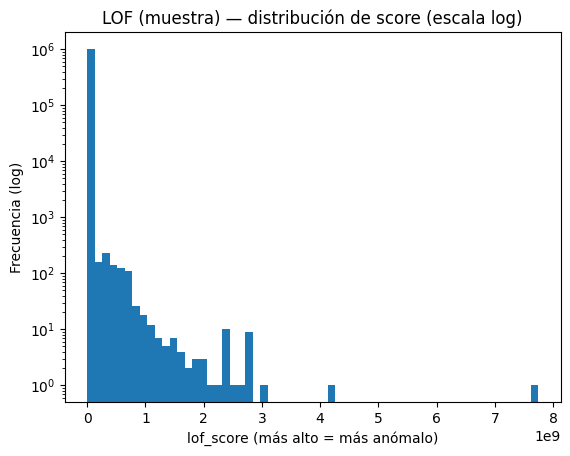

In [16]:
#Distribución de score
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lof_pred["lof_score"], bins=60)
plt.yscale("log")
plt.title("LOF (muestra) — distribución de score (escala log)")
plt.xlabel("lof_score (más alto = más anómalo)")
plt.ylabel("Frecuencia (log)")
plt.show()


In [17]:
#Tasa de alerta LOF (en muestra)
alert_rate_lof = (lof_pred["lof_label"] == -1).mean()
print("Alert rate LOF (muestra):", f"{alert_rate_lof:.2%}")

Alert rate LOF (muestra): 1.85%


In [18]:
# Claves de trazabilidad
keys = ["dt", "src_user"]

# Nos quedamos con lo que necesitamos (evita columnas duplicadas)
lof_keys = lof_pred[keys + ["lof_score"]].copy()
eval_keys = df_eval[keys + ["iso_score", "ae_score"]].copy()

# Unión por trazabilidad
df_sample = eval_keys.merge(lof_keys, on=keys, how="inner")

print("df_sample:", df_sample.shape)
df_sample.head()

df_sample: (5308137, 5)


,dt,src_user,iso_score,ae_score,lof_score
0,1970-01-01 00:00:00,U628@DOM1,0.090607,0.000094,-0.141727
1,1970-01-01 00:00:00,U49@DOM1,0.024662,0.002059,-0.141727
2,1970-01-01 00:00:00,U488@DOM1,0.149593,0.000273,-0.141727
3,1970-01-01 00:00:00,U68@DOM1,-0.159905,0.019234,0.051618
4,1970-01-01 00:00:00,U209@DOM1,0.149593,0.000273,-0.141727


In [19]:
K = 10000

top_lof = set(df_sample.nlargest(K, "lof_score").index)
top_if  = set(df_sample.nsmallest(K, "iso_score").index)   # IF: más bajo = más anómalo
top_ae  = set(df_sample.nlargest(K, "ae_score").index)     # AE: más alto = más anómalo

print("Overlap LOF vs IF:", len(top_lof & top_if) / K)
print("Overlap LOF vs AE:", len(top_lof & top_ae) / K)

Overlap LOF vs IF: 0.0035
Overlap LOF vs AE: 0.0053


El solapamiento entre LOF e Isolation Forest resulta prácticamente nulo en la muestra evaluada, mientras que la coincidencia con Autoencoders es inferior al 1%. Este comportamiento refleja la naturaleza local del algoritmo LOF, altamente dependiente de la densidad relativa del subconjunto analizado. 
En entornos de gran volumen, dicha sensibilidad puede generar detecciones divergentes respecto a modelos de enfoque global, reduciendo su utilidad como mecanismo de consenso para priorización de revisiones.

In [20]:
#consenso
K = 2000

df_lof_top = df_sample.nlargest(K, "lof_score").copy()

print("Top-K LOF:", df_lof_top.shape)
df_lof_top.head()

Top-K LOF: (2000, 5)


,dt,src_user,iso_score,ae_score,lof_score
2339873,1970-02-02 02:00:00,U199@DOM1,0.010934,0.402144,7.744082e+09
2339874,1970-02-02 02:00:00,U199@DOM1,0.010934,0.066799,7.744082e+09
2339875,1970-02-02 02:00:00,U199@DOM1,0.010934,4.185687,7.744082e+09
2340185,1970-02-02 02:00:00,U199@DOM1,-0.064930,0.402144,7.744082e+09
2340186,1970-02-02 02:00:00,U199@DOM1,-0.064930,0.066799,7.744082e+09


In [22]:
keys = ["dt", "src_user"]

df_lof_top = df_lof_top.merge(
    df_full[keys + DB_COLS],
    on=keys,
    how="left"
)

print(df_lof_top.shape)

(46110, 12)


In [23]:
comparison_lof = pd.concat(
    {
        "Global": df_full[DB_COLS].mean(),
        "LOF_TopK": df_lof_top[DB_COLS].mean()
    },
    axis=1
)

comparison_lof

,Global,LOF_TopK
total_events,26.529343,24.883561
failed_events,0.354660,4.618412
fail_ratio,0.008910,0.304811
dst_hosts,2.869009,3.123986
src_hosts,3.423033,3.607178
nbhours_events,5.098444,6.075515
nbhours_ratio,0.181240,0.129148


## Conclusión

Los resultados obtenidos muestran que tanto Isolation Forest como Autoencoders son capaces de identificar perfiles de comportamiento atípicos de forma no supervisada. El análisis de consenso entre ambos modelos evidencia un conjunto reducido de perfiles con características claramente anómalas, coherentes con patrones de riesgo en entornos IAM.

Este enfoque permite priorizar revisiones de seguridad sin necesidad de etiquetas ni revisión manual exhaustiva, contribuyendo a la reducción del coste operativo y mejorando la eficiencia de los procesos de monitorización de accesos.
